In [1]:
!nvidia-smi

Tue Jul  6 12:07:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:04:00.0 Off |                  N/A |
| 23%   30C    P8     7W / 250W |      1MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:05:00.0 Off |                  N/A |
| 23%   

In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sklearn
sklearn.__version__

'0.20.0'

In [2]:
import os
import time
import requests
import pandas as pd
import numpy as np
from pickle import load
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
from sodapy import Socrata
from sklearn.metrics import mean_absolute_error, mean_squared_error#,mean_absolute_percentage_error

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer
from attention import Attention

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [ ]:
#LOAD

In [ ]:
#Merge, remove null and na imputation

In [6]:
#today = "2021-05-27"
#today = "2021-12-02"
today = "2022-03-02"

In [7]:
#Vacunats

In [8]:
dfVac = pd.read_csv("data_flow/CASOS_VAC" + today + ".csv")

print(dfVac.shape)
print(dfVac.columns)

print(dfVac["regio_codi"].unique())
print(dfVac["regio"].unique())
print(dfVac["data"].iloc[-5:])
print((dfVac["regio_codi"]==0).sum())
print(dfVac["dosi"].unique())

dfVac["recompte"] = pd.to_numeric(dfVac["recompte"])
dfVac["data"] = pd.to_datetime(dfVac["data"])
dfVac.sort_values("data",ascending=True, inplace=True)

print(dfVac[dfVac["regio_codi"]==7803].shape)

(9539, 6)
Index(['data', 'regio_codi', 'regio', 'dosi', 'no_vacunat', 'recompte'], dtype='object')
[6100 6200 6300 6400 6700 7100 7801 7802 7803    0]
['LLEIDA' 'CAMP DE TARRAGONA' "TERRES DE L'EBRE" 'GIRONA'
 'CATALUNYA CENTRAL' 'ALT PIRINEU I ARAN' 'METROPOLITANA SUD'
 'METROPOLITANA NORD' 'BARCELONA CIUTAT' 'No classificat']
9534    2022-02-28
9535    2022-02-28
9536    2022-02-28
9537    2022-02-28
9538    2022-02-28
Name: data, dtype: object
935
[1 2 3]
(997, 6)


In [9]:
# calculate cases by computing the mean of the last 7 days reported cases

dfVac_r_6200_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6200, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6200_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6200, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7803_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7803, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7803_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7803, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6700_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6700, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6700_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6700, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7801_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7801, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7801_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7801, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6400_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6400, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6400_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6400, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7802_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7802, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7802_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7802, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6100_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6100, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6100_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6100, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7100_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7100, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7100_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7100, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6300_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6300, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6300_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6300, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_0_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==0, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_0_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==0, dfVac["dosi"]==2)][["data","recompte"]]

print(dfVac_r_0_v1.shape, dfVac_r_7803_v1.shape,dfVac_r_6700_v1.shape,dfVac_r_7801_v1.shape,
     dfVac_r_6400_v1.shape,dfVac_r_7802_v1.shape,dfVac_r_6200_v1.shape,dfVac_r_6100_v1.shape,
     dfVac_r_7100_v1.shape,dfVac_r_6300_v1.shape)

(413, 2) (426, 2) (421, 2) (423, 2) (418, 2) (426, 2) (413, 2) (398, 2) (380, 2) (398, 2)


In [10]:
dfVacAll = None
dfVacAll = pd.merge(dfVac_r_6200_v1,dfVac_r_7803_v1,how="left", on="data",suffixes=("_r_6200_v1","_r_7803_v1"))

dfVacAll = pd.merge(dfVacAll, dfVac_r_6700_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6700_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7801_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7801_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6400_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6400_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7802_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7802_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_0_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_0_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6100_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6100_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7100_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7100_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6300_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6300_v1'}, inplace = True)

In [11]:
#dfVacAll.plot(x="data", figsize=(15,8))

In [12]:
dfVacAll = pd.merge(dfVacAll,dfVac_r_0_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_0_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7803_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7803_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6700_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6700_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7801_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7801_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6400_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6400_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7802_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7802_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6200_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6200_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6100_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6100_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7100_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7100_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6300_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6300_v2'}, inplace = True)

dfVacAll.tail()

,data,recompte_r_6200_v1,recompte_r_7803_v1,recompte_r_6700_v1,recompte_r_7801_v1,recompte_r_6400_v1,recompte_r_7802_v1,recompte_r_0_v1,recompte_r_6100_v1,recompte_r_7100_v1,...,recompte_r_0_v2,recompte_r_7803_v2,recompte_r_6700_v2,recompte_r_7801_v2,recompte_r_6400_v2,recompte_r_7802_v2,recompte_r_6200_v2,recompte_r_6100_v2,recompte_r_7100_v2,recompte_r_6300_v2
408,2022-02-23,44,143.0,72.0,67.0,85.0,103,20.0,46.0,1.0,...,19.0,1127.0,419.0,1222.0,794.0,1245.0,667.0,318.0,28.0,113.0
409,2022-02-24,30,153.0,35.0,83.0,123.0,143,27.0,46.0,10.0,...,16.0,1387.0,514.0,1082.0,969.0,1393.0,508.0,439.0,27.0,194.0
410,2022-02-25,48,195.0,47.0,144.0,92.0,145,15.0,47.0,2.0,...,11.0,1596.0,433.0,1557.0,627.0,1227.0,522.0,320.0,14.0,150.0
411,2022-02-26,60,24.0,NaN,123.0,4.0,141,4.0,NaN,NaN,...,NaN,345.0,24.0,1219.0,15.0,1431.0,524.0,1.0,NaN,32.0
412,2022-02-28,41,68.0,23.0,71.0,30.0,86,7.0,32.0,10.0,...,4.0,929.0,129.0,1079.0,310.0,1168.0,490.0,264.0,28.0,140.0


In [13]:
#NAN
print(len(dfVacAll.columns))
print(dfVacAll.columns)
print(dfVacAll.isnull().sum(axis=0))
dfVacAll.fillna(0,inplace=True)
#dfVacAll = dfVacAll.iloc[10:]
print(dfVacAll.isnull().sum(axis=0))

21
Index(['data', 'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_0_v2',
       'recompte_r_7803_v2', 'recompte_r_6700_v2', 'recompte_r_7801_v2',
       'recompte_r_6400_v2', 'recompte_r_7802_v2', 'recompte_r_6200_v2',
       'recompte_r_6100_v2', 'recompte_r_7100_v2', 'recompte_r_6300_v2'],
      dtype='object')
data                   0
recompte_r_6200_v1     0
recompte_r_7803_v1     1
recompte_r_6700_v1     3
recompte_r_7801_v1     2
recompte_r_6400_v1     1
recompte_r_7802_v1     0
recompte_r_0_v1        8
recompte_r_6100_v1    18
recompte_r_7100_v1    36
recompte_r_6300_v1    19
recompte_r_0_v2       43
recompte_r_7803_v2    22
recompte_r_6700_v2    28
recompte_r_7801_v2    22
recompte_r_6400_v2    29
recompte_r_7802_v2    21
recompte_r_6200_v2    31
recompte_r_6100_v2    39
recompte

In [14]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = dfVacAll.columns
print(cols)
for k in range(1,len(cols)):
    zn = []
    for i in range(dfVacAll.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfVacAll.iloc[i-j,k]
        zn.append(acc/7)

    dfVacAll[cols[k] + "_7"] = zn
    
dfVacAll = dfVacAll[["data",
       'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_6200_v2', 
       'recompte_r_7803_v2',
       'recompte_r_6700_v2', 'recompte_r_7801_v2', 'recompte_r_6400_v2',
       'recompte_r_7802_v2', 'recompte_r_0_v2', 'recompte_r_6100_v2',
       'recompte_r_7100_v2', 'recompte_r_6300_v2',       
       'recompte_r_6200_v1_7', 'recompte_r_7803_v1_7',
       'recompte_r_6700_v1_7', 'recompte_r_7801_v1_7', 'recompte_r_6400_v1_7',
       'recompte_r_7802_v1_7', 'recompte_r_0_v1_7', 'recompte_r_6100_v1_7',
       'recompte_r_7100_v1_7', 'recompte_r_6300_v1_7', 'recompte_r_6200_v2_7', 
       'recompte_r_7803_v2_7',
       'recompte_r_6700_v2_7', 'recompte_r_7801_v2_7', 'recompte_r_6400_v2_7',
       'recompte_r_7802_v2_7', 'recompte_r_0_v2_7', 'recompte_r_6100_v2_7',
       'recompte_r_7100_v2_7', 'recompte_r_6300_v2_7',                  
                    ]]

print(len(dfVacAll.columns))
dfVacAll

Index(['data', 'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_0_v2',
       'recompte_r_7803_v2', 'recompte_r_6700_v2', 'recompte_r_7801_v2',
       'recompte_r_6400_v2', 'recompte_r_7802_v2', 'recompte_r_6200_v2',
       'recompte_r_6100_v2', 'recompte_r_7100_v2', 'recompte_r_6300_v2'],
      dtype='object')
41


,data,recompte_r_6200_v1,recompte_r_7803_v1,recompte_r_6700_v1,recompte_r_7801_v1,recompte_r_6400_v1,recompte_r_7802_v1,recompte_r_0_v1,recompte_r_6100_v1,recompte_r_7100_v1,...,recompte_r_6200_v2_7,recompte_r_7803_v2_7,recompte_r_6700_v2_7,recompte_r_7801_v2_7,recompte_r_6400_v2_7,recompte_r_7802_v2_7,recompte_r_0_v2_7,recompte_r_6100_v2_7,recompte_r_7100_v2_7,recompte_r_6300_v2_7
0,2020-12-27,112,58.0,87.0,84.0,76.0,161,0.0,68.0,79.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-12-30,173,441.0,295.0,401.0,127.0,648,16.0,364.0,91.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-12-31,191,665.0,228.0,231.0,80.0,569,4.0,504.0,112.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2021-01-02,3,602.0,401.0,111.0,234.0,615,0.0,46.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2021-01-03,1,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,2022-02-23,44,143.0,72.0,67.0,85.0,103,20.0,46.0,1.0,...,468.285714,1122.428571,342.000000,1042.428571,669.285714,1336.000000,17.571429,296.571429,48.571429,95.142857
409,2022-02-24,30,153.0,35.0,83.0,123.0,143,27.0,46.0,10.0,...,479.285714,1166.285714,353.142857,1044.142857,703.142857,1290.571429,16.428571,308.285714,39.857143,104.428571
410,2022-02-25,48,195.0,47.0,144.0,92.0,145,15.0,47.0,2.0,...,495.428571,1211.714286,355.571429,1125.285714,662.714286,1199.857143,14.000000,307.000000,26.000000,100.000000
411,2022-02-26,60,24.0,0.0,123.0,4.0,141,4.0,0.0,0.0,...,479.571429,1026.571429,271.857143,1118.571429,534.857143,1187.857143,10.857143,224.857143,22.714286,85.428571


In [15]:
#Incidence x regio

In [16]:
dfInc = pd.read_csv("data_flow/CASOS_UCI" + today + ".csv")
dfInc.tail()

#group by date and regiosanitaria
dfInc = dfInc[["data","casos_confirmat","ingressos_critic","ingressos_total","ingressats_critic",
              "ingressats_total","regiosanitariacodi"]]
grp = dfInc.groupby(["data","regiosanitariacodi"]).agg("sum")
dfInc = grp.reset_index()
dfInc

,data,regiosanitariacodi,casos_confirmat,ingressos_critic,ingressos_total,ingressats_critic,ingressats_total
0,2020-03-01,6100,0,0,0,0,0
1,2020-03-01,6200,0,0,0,0,0
2,2020-03-01,6300,0,0,0,0,0
3,2020-03-01,6400,2,0,0,0,0
4,2020-03-01,6700,0,0,0,0,0
...,...,...,...,...,...,...,...
6574,2022-03-01,6700,172,0,0,14,100
6575,2022-03-01,7100,26,0,0,0,8
6576,2022-03-01,7801,365,0,3,26,174
6577,2022-03-01,7802,616,3,0,54,337


In [17]:
print(dfInc.shape)
print(dfInc.columns)
print(dfInc["regiosanitariacodi"].unique())
print(dfInc["data"].iloc[-5:])
print((dfInc["regiosanitariacodi"]==0).sum())


dfInc["casos_confirmat"] = pd.to_numeric(dfInc["casos_confirmat"])
dfInc["ingressos_critic"] = pd.to_numeric(dfInc["ingressos_critic"])
dfInc["ingressos_total"] = pd.to_numeric(dfInc["ingressos_total"])
dfInc["ingressats_critic"] = pd.to_numeric(dfInc["ingressats_critic"])
dfInc["ingressats_total"] = pd.to_numeric(dfInc["ingressats_total"])
dfInc["data"] = pd.to_datetime(dfInc["data"])
dfInc.sort_values("data",ascending=True, inplace=True)

print(dfInc[dfInc["regiosanitariacodi"]==7803].shape)

(6579, 7)
Index(['data', 'regiosanitariacodi', 'casos_confirmat', 'ingressos_critic',
       'ingressos_total', 'ingressats_critic', 'ingressats_total'],
      dtype='object')
[6100 6200 6300 6400 6700 7100 7801 7802 7803]
6574    2022-03-01
6575    2022-03-01
6576    2022-03-01
6577    2022-03-01
6578    2022-03-01
Name: data, dtype: object
0
(731, 7)


In [18]:
# Tranform data
#dfInc_r_0 = dfInc[dfInc["regiosanitariacodi"]==0][["data","ingressats_critic"]]
dfInc_r_7803 = dfInc[dfInc["regiosanitariacodi"]==7803][["data","ingressats_critic"]]
dfInc_r_6700 = dfInc[dfInc["regiosanitariacodi"]==6700][["data","ingressats_critic"]]
dfInc_r_7801 = dfInc[dfInc["regiosanitariacodi"]==7801][["data","ingressats_critic"]]
dfInc_r_6400 = dfInc[dfInc["regiosanitariacodi"]==6400][["data","ingressats_critic"]]
dfInc_r_7802 = dfInc[dfInc["regiosanitariacodi"]==7802][["data","ingressats_critic"]]
dfInc_r_6200 = dfInc[dfInc["regiosanitariacodi"]==6200][["data","ingressats_critic"]]
dfInc_r_6100 = dfInc[dfInc["regiosanitariacodi"]==6100][["data","ingressats_critic"]]
dfInc_r_7100 = dfInc[dfInc["regiosanitariacodi"]==7100][["data","ingressats_critic"]]
dfInc_r_6300 = dfInc[dfInc["regiosanitariacodi"]==6300][["data","ingressats_critic"]]
print(dfInc_r_7803.shape,dfInc_r_6700.shape,dfInc_r_7801.shape)

#dfInc = pd.merge(dfInc_r_0,dfInc_r_7803,how="left", on="data",suffixes=("_r_0","_r_7803"))
dfInc = pd.merge(dfInc_r_7803,dfInc_r_6700,how="left", on="data",suffixes=("_r_7803","_r_6700"))
dfInc = pd.merge(dfInc,dfInc_r_7801,how="left", on="data",suffixes=("_r_6700","_r_7801"))
dfInc = pd.merge(dfInc,dfInc_r_6400,how="left", on="data",suffixes=("_r_7801","_r_6400"))
dfInc = pd.merge(dfInc,dfInc_r_7802,how="left", on="data",suffixes=("_r_6400","_r_7802"))
dfInc = pd.merge(dfInc,dfInc_r_6200,how="left", on="data",suffixes=("_r_7802","_r_6200"))
dfInc = pd.merge(dfInc,dfInc_r_6100,how="left", on="data",suffixes=("_r_6200","_r_6100"))
dfInc = pd.merge(dfInc,dfInc_r_7100,how="left", on="data",suffixes=("_r_6100","_r_7100"))
dfInc = pd.merge(dfInc,dfInc_r_6300,how="left", on="data",suffixes=("_r_7100","_r_6300"))
dfInc = pd.merge(dfInc,dfInc_r_6300,how="left", on="data",suffixes=("_r_6300","_r_6300_1"))

dfInc = dfInc[['data', 'ingressats_critic_r_7803', 'ingressats_critic_r_6700',
       'ingressats_critic_r_7801', 'ingressats_critic_r_6400',
       'ingressats_critic_r_7802', 'ingressats_critic_r_6200',
       'ingressats_critic_r_6100', 'ingressats_critic_r_7100',
       'ingressats_critic_r_6300']]
print(dfInc.shape)
print(dfInc.columns)
dfInc.tail(50)

(731, 2) (731, 2) (731, 2)
(731, 10)
Index(['data', 'ingressats_critic_r_7803', 'ingressats_critic_r_6700',
       'ingressats_critic_r_7801', 'ingressats_critic_r_6400',
       'ingressats_critic_r_7802', 'ingressats_critic_r_6200',
       'ingressats_critic_r_6100', 'ingressats_critic_r_7100',
       'ingressats_critic_r_6300'],
      dtype='object')


,data,ingressats_critic_r_7803,ingressats_critic_r_6700,ingressats_critic_r_7801,ingressats_critic_r_6400,ingressats_critic_r_7802,ingressats_critic_r_6200,ingressats_critic_r_6100,ingressats_critic_r_7100,ingressats_critic_r_6300
681,2022-01-11,77,37,36,59,125,36,21,3,13
682,2022-01-12,82,38,41,60,119,36,22,3,13
683,2022-01-13,84,40,39,59,120,38,21,2,11
684,2022-01-14,88,42,42,60,121,40,20,2,11
685,2022-01-15,89,45,42,58,127,40,18,2,10
686,2022-01-16,87,42,43,62,118,40,18,2,12
687,2022-01-17,81,39,40,59,124,41,17,2,12
688,2022-01-18,86,38,39,52,117,40,20,2,12
689,2022-01-19,83,36,40,52,132,38,22,1,13
690,2022-01-20,84,36,44,54,131,36,22,2,12


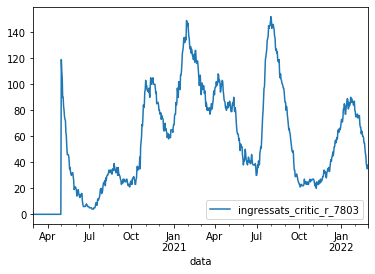

In [19]:
dfInc[["data","ingressats_critic_r_7803"]].plot(x="data")

In [20]:
#NAN
print(dfInc.isnull().sum(axis=0))
dfInc.fillna(0,inplace=True)
print(dfInc.isnull().sum(axis=0))

data                        0
ingressats_critic_r_7803    0
ingressats_critic_r_6700    0
ingressats_critic_r_7801    0
ingressats_critic_r_6400    0
ingressats_critic_r_7802    0
ingressats_critic_r_6200    0
ingressats_critic_r_6100    0
ingressats_critic_r_7100    0
ingressats_critic_r_6300    0
dtype: int64
data                        0
ingressats_critic_r_7803    0
ingressats_critic_r_6700    0
ingressats_critic_r_7801    0
ingressats_critic_r_6400    0
ingressats_critic_r_7802    0
ingressats_critic_r_6200    0
ingressats_critic_r_6100    0
ingressats_critic_r_7100    0
ingressats_critic_r_6300    0
dtype: int64


In [21]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = [
       'data',
       'ingressats_critic_r_7803', 'ingressats_critic_r_6700',
       'ingressats_critic_r_7801', 'ingressats_critic_r_6400',
       'ingressats_critic_r_7802', 'ingressats_critic_r_6200',
       'ingressats_critic_r_6100', 'ingressats_critic_r_7100',
       'ingressats_critic_r_6300'
]
print(cols)
dfInc = dfInc[cols]
for k in range(1,len(cols)):
    print(k,cols[k])
    dfInc[cols[k]] = pd.to_numeric(dfInc[cols[k]])
    zn = []
    for i in range(dfInc.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfInc.iloc[i-j,k]
        zn.append(acc/7)

    dfInc[cols[k] + "_7"] = zn
    
dfInc = dfInc[["data",
               'ingressats_critic_r_7803', 'ingressats_critic_r_6700',
               'ingressats_critic_r_7801', 'ingressats_critic_r_6400', 'ingressats_critic_r_7802',
               'ingressats_critic_r_6200', 'ingressats_critic_r_6100', 'ingressats_critic_r_7100',
               'ingressats_critic_r_6300',
               'ingressats_critic_r_7803_7', 'ingressats_critic_r_6700_7',
               'ingressats_critic_r_7801_7', 'ingressats_critic_r_6400_7', 'ingressats_critic_r_7802_7',
               'ingressats_critic_r_6200_7', 'ingressats_critic_r_6100_7', 'ingressats_critic_r_7100_7',
               'ingressats_critic_r_6300_7']]
print(dfInc.shape)
dfInc

['data', 'ingressats_critic_r_7803', 'ingressats_critic_r_6700', 'ingressats_critic_r_7801', 'ingressats_critic_r_6400', 'ingressats_critic_r_7802', 'ingressats_critic_r_6200', 'ingressats_critic_r_6100', 'ingressats_critic_r_7100', 'ingressats_critic_r_6300']
1 ingressats_critic_r_7803
2 ingressats_critic_r_6700
3 ingressats_critic_r_7801
4 ingressats_critic_r_6400
5 ingressats_critic_r_7802
6 ingressats_critic_r_6200
7 ingressats_critic_r_6100
8 ingressats_critic_r_7100
9 ingressats_critic_r_6300
(731, 19)


,data,ingressats_critic_r_7803,ingressats_critic_r_6700,ingressats_critic_r_7801,ingressats_critic_r_6400,ingressats_critic_r_7802,ingressats_critic_r_6200,ingressats_critic_r_6100,ingressats_critic_r_7100,ingressats_critic_r_6300,ingressats_critic_r_7803_7,ingressats_critic_r_6700_7,ingressats_critic_r_7801_7,ingressats_critic_r_6400_7,ingressats_critic_r_7802_7,ingressats_critic_r_6200_7,ingressats_critic_r_6100_7,ingressats_critic_r_7100_7,ingressats_critic_r_6300_7
0,2020-03-01,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,2020-03-02,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,2020-03-03,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,2020-03-04,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,2020-03-05,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2022-02-25,39,13,31,31,49,16,9,0,8,50.142857,17.714286,33.142857,35.714286,63.000000,17.857143,12.142857,0.0,9.285714
727,2022-02-26,37,13,29,29,49,17,9,0,9,47.000000,16.857143,32.571429,34.000000,59.714286,17.285714,11.428571,0.0,9.285714
728,2022-02-27,35,14,31,30,49,16,9,0,10,44.142857,16.142857,32.428571,32.285714,56.285714,16.714286,10.714286,0.0,9.428571
729,2022-02-28,36,13,28,29,55,16,7,0,8,41.428571,15.285714,31.857143,30.571429,54.142857,16.285714,9.857143,0.0,9.285714


In [22]:
#Forecasting predictions!!

In [23]:
mapRegId = {
 '0000': 'No classificat',
 '7803': 'BARCELONA CIUTAT',
 '6700': 'CATALUNYA CENTRAL',
 '7801': 'METROPOLITANA SUD',
 '6400': 'GIRONA',
 '7802': 'METROPOLITANA NORD',
 '6200': 'CAMP DE TARRAGONA',
 '6100': 'LLEIDA',
 '7100': 'ALT PIRINEU I ARAN',
 '6300': "TERRES DE L'EBRE"    
}

In [24]:
selCodisReg = ['6100', '6200', '6300', '6400', '6700', '7100', '7801', '7802','7803']

In [25]:
modelNames = [
    "uci_occupancy_best_model_region_shallow.02122021.",
    "uci_occupancy_best_model_region_shallow_vacc.02122021.",
    "uci_occupancy_best_model_region_vacc_mean7.02122021."
]

In [39]:
#Get cls

In [26]:
preds_all = []
for cls in modelNames:
    for cod in selCodisReg:

        fname = cls+cod   
        print("\n" + str(cod) + " " + mapRegId[str(cod)] + "\n")
        print(fname)

        #Merge data
        start = time.time()
        dfAll = pd.merge(dfInc[["data",'ingressats_critic_r_'+cod,'ingressats_critic_r_'+cod+'_7']],
                         dfVacAll[["data","recompte_r_"+cod+"_v1","recompte_r_"+cod+"_v2",
                                   "recompte_r_"+cod+"_v1_7","recompte_r_"+cod+"_v2_7"]], 
                         how="left",on="data",suffixes=("",""))
        
        #Filter dates
        d1 = pd.Timestamp(2021, 12, 2)
        dfAll["data"] = pd.to_datetime(dfAll["data"])
        dfAll = dfAll[dfAll["data"]<=d1]
        dfAll.fillna(0,inplace=True)

        #Remove last days 
        dfAll = dfAll.iloc[:-1]
        dateIni = str(dfAll.iloc[-1]["data"])[:-9]
        dateFi = str(dfAll.iloc[0]["data"])[:-9]
        print(dateIni, dateFi)
          

        #Convert data to format (rows,timepoints,features)
        if "mean7" in fname:
            cols = [
                 'ingressats_critic_r_'+cod, 'ingressats_critic_r_'+cod+'_7', 
                 'recompte_r_'+cod+'_v1','recompte_r_'+cod+'_v2', 
                 'recompte_r_'+cod+'_v1_7', 'recompte_r_'+cod+'_v2_7'] 
        elif "shallow_vacc" in fname:
            cols = [
               'ingressats_critic_r_'+cod,
               'recompte_r_'+cod+'_v1','recompte_r_'+cod+'_v2']
        elif "shallow" in fname:
            cols = [
               'ingressats_critic_r_'+cod]
            
        print(cols)
        ncols=len(cols)
        res = series_to_supervised(dfAll.loc[:,cols].values,21,21,dropnan=False)   

        #Patition train/test
        data_X = res.iloc[:,:(21*ncols)].values.reshape(-1,21,ncols)
        real_all = res.iloc[:,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)  

        # normalize features
        scalers_X = []
        for i in range(data_X.shape[-1]):
            print(fname + "_scaler_tr_X_" + str(i)+'.pkl')
            scaler = load(open("models/"+ fname + "_scaler_tr_X_" + str(i)+'.pkl', 'rb'))
            data_X[:,:,i] = scaler.transform(data_X[:,:,i])
        scaler_y = load(open("models/"+ fname + "_scaler_tr_Y.pkl", 'rb'))

        #Evaluate
        preds_region = []
        for cc in range(5):
            print("Loading...", "models/"+ fname + "_" + str(cc) +'.h5')
            model = tf.keras.models.load_model("models/"+ fname + "_" + str(cc) +'.h5')
            preds = model.predict(data_X)
            preds_region.append(scaler_y.inverse_transform(preds))
        preds_all.append(preds_region)
        preds_region = np.array(preds_region).reshape(5,data_X.shape[0],data_X.shape[1])
        np.save(os.getcwd()+"/results/res_"+ fname +'.npy', preds_region)


6100 LLEIDA

uci_occupancy_best_model_region_shallow.02122021.6100
2021-12-01 2020-03-01
['ingressats_critic_r_6100']
uci_occupancy_best_model_region_shallow.02122021.6100_scaler_tr_X_0.pkl
Loading... models/uci_occupancy_best_model_region_shallow.02122021.6100_0.h5
Loading... models/uci_occupancy_best_model_region_shallow.02122021.6100_1.h5
Loading... models/uci_occupancy_best_model_region_shallow.02122021.6100_2.h5
Loading... models/uci_occupancy_best_model_region_shallow.02122021.6100_3.h5
Loading... models/uci_occupancy_best_model_region_shallow.02122021.6100_4.h5

6200 CAMP DE TARRAGONA

uci_occupancy_best_model_region_shallow.02122021.6200
2021-12-01 2020-03-01
['ingressats_critic_r_6200']
uci_occupancy_best_model_region_shallow.02122021.6200_scaler_tr_X_0.pkl
Loading... models/uci_occupancy_best_model_region_shallow.02122021.6200_0.h5
Loading... models/uci_occupancy_best_model_region_shallow.02122021.6200_1.h5
Loading... models/uci_occupancy_best_model_region_shallow.02122021.6

Loading... models/uci_occupancy_best_model_region_shallow_vacc.02122021.6400_2.h5
Loading... models/uci_occupancy_best_model_region_shallow_vacc.02122021.6400_3.h5
Loading... models/uci_occupancy_best_model_region_shallow_vacc.02122021.6400_4.h5

6700 CATALUNYA CENTRAL

uci_occupancy_best_model_region_shallow_vacc.02122021.6700
2021-12-01 2020-03-01
['ingressats_critic_r_6700', 'recompte_r_6700_v1', 'recompte_r_6700_v2']
uci_occupancy_best_model_region_shallow_vacc.02122021.6700_scaler_tr_X_0.pkl
uci_occupancy_best_model_region_shallow_vacc.02122021.6700_scaler_tr_X_1.pkl
uci_occupancy_best_model_region_shallow_vacc.02122021.6700_scaler_tr_X_2.pkl
Loading... models/uci_occupancy_best_model_region_shallow_vacc.02122021.6700_0.h5
Loading... models/uci_occupancy_best_model_region_shallow_vacc.02122021.6700_1.h5
Loading... models/uci_occupancy_best_model_region_shallow_vacc.02122021.6700_2.h5
Loading... models/uci_occupancy_best_model_region_shallow_vacc.02122021.6700_3.h5
Loading... model

Loading... models/uci_occupancy_best_model_region_vacc_mean7.02122021.6400_1.h5
Loading... models/uci_occupancy_best_model_region_vacc_mean7.02122021.6400_2.h5
Loading... models/uci_occupancy_best_model_region_vacc_mean7.02122021.6400_3.h5
Loading... models/uci_occupancy_best_model_region_vacc_mean7.02122021.6400_4.h5

6700 CATALUNYA CENTRAL

uci_occupancy_best_model_region_vacc_mean7.02122021.6700
2021-12-01 2020-03-01
['ingressats_critic_r_6700', 'ingressats_critic_r_6700_7', 'recompte_r_6700_v1', 'recompte_r_6700_v2', 'recompte_r_6700_v1_7', 'recompte_r_6700_v2_7']
uci_occupancy_best_model_region_vacc_mean7.02122021.6700_scaler_tr_X_0.pkl
uci_occupancy_best_model_region_vacc_mean7.02122021.6700_scaler_tr_X_1.pkl
uci_occupancy_best_model_region_vacc_mean7.02122021.6700_scaler_tr_X_2.pkl
uci_occupancy_best_model_region_vacc_mean7.02122021.6700_scaler_tr_X_3.pkl
uci_occupancy_best_model_region_vacc_mean7.02122021.6700_scaler_tr_X_4.pkl
uci_occupancy_best_model_region_vacc_mean7.0212202

In [26]:
# EVALUATION 
# Validation: 2021-03-27
# Test: 2021-05-27


uci_occupancy_best_model_region_shallow.02122021.
6100
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 2.28 MAPE: 0.53 CUM-MAE: 93.24 CUM-MAPE: 0.68 R2: 0.81
7 56 MAE: 1.74 MAPE: 0.38 CUM-MAE: 66.87 CUM-MAPE: 0.63 R2: 0.54
14 49 MAE: 1.54 MAPE: 0.26 CUM-MAE: 48.85 CUM-MAPE: 0.39 R2: 0.66
21 42 MAE: 1.6 MAPE: 0.26 CUM-MAE: 43.8 CUM-MAPE: 0.37 R2: 0.59
(62, 21)
ALL 62 MAE: 1.48 MAPE: 0.26 CUM-MAE: 65.18 CUM-MAPE: 0.46 R2: 0.81
6200
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 3.65 MAPE: 0.38 CUM-MAE: 118.32 CUM-MAPE: 0.39 R2: 0.35
7 56 MAE: 3.5 MAPE: 0.36 CUM-MAE: 99.33 CUM-MAPE: 0.3 R2: -0.18
14 49 MAE: 4.33 MAPE: 0.45 CUM-MAE: 109.62 CUM-MAPE: 0.4 R2: -0.02
21 42 MAE: 4.38 MAPE: 0.46 CUM-MAE: 95.44 CUM-MAPE: 0.4 R2: -0.3
(62, 21)
ALL 62 MAE: 3.72 MAPE: 0.36 CUM-MAE: 124.01 CUM-MAPE: 0.37 R2: -0.24
6300
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 0.75 MAPE: 

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/

ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 2.0 MAPE: 0.1 CUM-MAE: 29.2 CUM-MAPE: 0.04 R2: 0.93
7 56 MAE: 5.14 MAPE: 0.27 CUM-MAE: 132.94 CUM-MAPE: 0.28 R2: 0.48
14 49 MAE: 8.91 MAPE: 0.51 CUM-MAE: 251.9 CUM-MAPE: 0.68 R2: -0.24
21 42 MAE: 12.74 MAPE: 0.76 CUM-MAE: 349.53 CUM-MAPE: 1.09 R2: -0.43
(62, 21)
ALL 62 MAE: 6.1 MAPE: 0.31 CUM-MAE: 200.53 CUM-MAPE: 0.42 R2: 0.37
7803
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 1.65 MAPE: 0.06 CUM-MAE: 13.01 CUM-MAPE: 0.02 R2: 0.84
7 56 MAE: 3.71 MAPE: 0.15 CUM-MAE: 82.29 CUM-MAPE: 0.09 R2: 0.44
14 49 MAE: 8.44 MAPE: 0.34 CUM-MAE: 201.35 CUM-MAPE: 0.28 R2: -0.08
21 42 MAE: 15.71 MAPE: 0.62 CUM-MAE: 317.69 CUM-MAPE: 0.53 R2: 0.13
(62, 21)
ALL 62 MAE: 5.87 MAPE: 0.23 CUM-MAE: 193.34 CUM-MAPE: 0.22 R2: 0.19

uci_occupancy_best_model_region_shallow_vacc.02122021.
6100
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 3.1 

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


ALL 62 MAE: 2.36 MAPE: 0.2 CUM-MAE: 25.76 CUM-MAPE: 0.12 R2: 0.81
7100
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 0.65 MAPE: 0.62 CUM-MAE: 21.83 CUM-MAPE: 0.71 R2: 0.53
7 56 MAE: 0.6 MAPE: 0.55 CUM-MAE: 16.93 CUM-MAPE: 0.59 R2: 0.29
14 49 MAE: 0.51 MAPE: 0.46 CUM-MAE: 11.64 CUM-MAPE: 0.45 R2: 0.87
21 42 MAE: 0.34 MAPE: 0.28 CUM-MAE: 5.89 CUM-MAPE: 0.26 R2: -0.11
(62, 21)
ALL 62 MAE: 0.55 MAPE: 0.5 CUM-MAE: 16.59 CUM-MAPE: 0.51 R2: 0.33
7801
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 10.71 MAPE: 1.63 CUM-MAE: 325.48 CUM-MAPE: 1.09 R2: 0.8
7 56 MAE: 11.48 MAPE: 1.8 CUM-MAE: 328.63 CUM-MAPE: 1.42 R2: 0.48
14 49 MAE: 11.98 MAPE: 1.96 CUM-MAE: 308.08 CUM-MAPE: 1.7 R2: 0.17
21 42 MAE: 11.88 MAPE: 2.0 CUM-MAE: 265.07 CUM-MAPE: 1.8 R2: 0.16
(62, 21)
ALL 62 MAE: 11.41 MAPE: 1.61 CUM-MAE: 368.9 CUM-MAPE: 1.52 R2: 0.54
7802
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


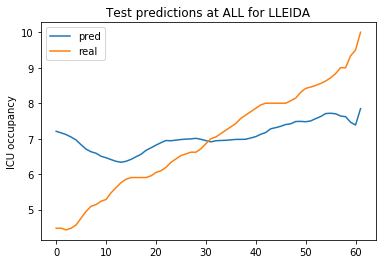

ALL 62 MAE: 0.97 MAPE: 0.16 CUM-MAE: 23.93 CUM-MAPE: 0.23 R2: 0.77
6200
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 1.09 MAPE: 0.12 CUM-MAE: 15.27 CUM-MAPE: 0.07 R2: 0.27
7 56 MAE: 2.15 MAPE: 0.23 CUM-MAE: 60.81 CUM-MAPE: 0.19 R2: -0.17
14 49 MAE: 2.43 MAPE: 0.26 CUM-MAE: 62.0 CUM-MAPE: 0.23 R2: -0.13
21 42 MAE: 2.05 MAPE: 0.22 CUM-MAE: 45.5 CUM-MAPE: 0.19 R2: -0.42
(62, 21)


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


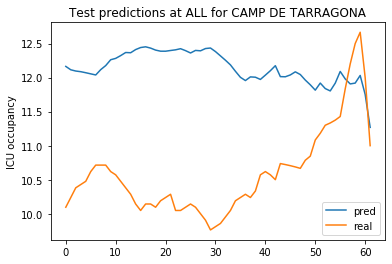

ALL 62 MAE: 1.61 MAPE: 0.16 CUM-MAE: 58.75 CUM-MAPE: 0.18 R2: -0.65
6300
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 0.63 MAPE: 0.42 CUM-MAE: 7.98 CUM-MAPE: 0.1 R2: 0.49
7 56 MAE: 0.69 MAPE: 0.39 CUM-MAE: 9.13 CUM-MAPE: 0.19 R2: 0.15
14 49 MAE: 1.43 MAPE: 1.07 CUM-MAE: 33.77 CUM-MAPE: 0.56 R2: -0.43
21 42 MAE: 1.65 MAPE: 1.26 CUM-MAE: 35.34 CUM-MAPE: 0.81 R2: -0.55
(62, 21)


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


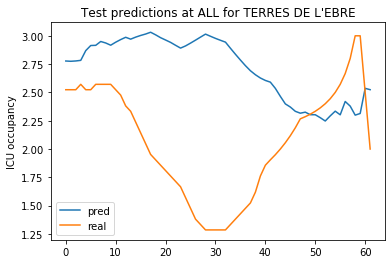

ALL 62 MAE: 0.74 MAPE: 0.44 CUM-MAE: 24.47 CUM-MAPE: 0.32 R2: -0.44
6400
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 1.33 MAPE: 0.14 CUM-MAE: 16.55 CUM-MAPE: 0.1 R2: 0.96
7 56 MAE: 3.41 MAPE: 0.32 CUM-MAE: 26.52 CUM-MAPE: 0.16 R2: 0.8
14 49 MAE: 4.7 MAPE: 0.43 CUM-MAE: 29.28 CUM-MAPE: 0.13 R2: 0.55
21 42 MAE: 5.79 MAPE: 0.49 CUM-MAE: 41.58 CUM-MAPE: 0.32 R2: 0.19
(62, 21)


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


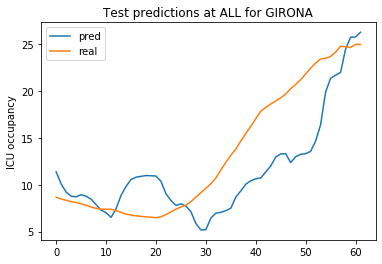

ALL 62 MAE: 3.59 MAPE: 0.28 CUM-MAE: 43.29 CUM-MAPE: 0.15 R2: 0.81
6700
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 1.39 MAPE: 0.14 CUM-MAE: 17.77 CUM-MAPE: 0.07 R2: 0.9
7 56 MAE: 2.11 MAPE: 0.24 CUM-MAE: 47.11 CUM-MAPE: 0.22 R2: 0.63
14 49 MAE: 2.73 MAPE: 0.32 CUM-MAE: 69.63 CUM-MAPE: 0.37 R2: 0.62
21 42 MAE: 3.14 MAPE: 0.36 CUM-MAE: 66.3 CUM-MAPE: 0.42 R2: 0.16
(62, 21)


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


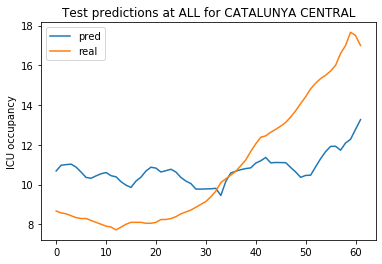

ALL 62 MAE: 2.27 MAPE: 0.21 CUM-MAE: 41.14 CUM-MAPE: 0.2 R2: 0.73
7100
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 0.65 MAPE: 0.63 CUM-MAE: 23.54 CUM-MAPE: 0.78 R2: 0.62
7 56 MAE: 0.55 MAPE: 0.51 CUM-MAE: 16.34 CUM-MAPE: 0.59 R2: 0.43
14 49 MAE: 0.54 MAPE: 0.49 CUM-MAE: 12.45 CUM-MAPE: 0.47 R2: 0.76
21 42 MAE: 0.52 MAPE: 0.45 CUM-MAE: 9.78 CUM-MAPE: 0.43 R2: -0.18
(62, 21)


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


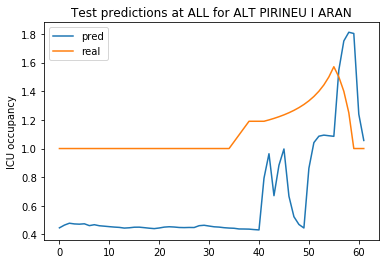

ALL 62 MAE: 0.52 MAPE: 0.48 CUM-MAE: 16.97 CUM-MAPE: 0.53 R2: 0.59
7801
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 4.82 MAPE: 0.76 CUM-MAE: 145.84 CUM-MAPE: 0.48 R2: 0.81
7 56 MAE: 9.78 MAPE: 1.54 CUM-MAE: 283.08 CUM-MAPE: 1.23 R2: 0.48
14 49 MAE: 10.52 MAPE: 1.73 CUM-MAE: 269.62 CUM-MAPE: 1.48 R2: 0.06
21 42 MAE: 14.82 MAPE: 2.48 CUM-MAE: 321.76 CUM-MAPE: 2.15 R2: -0.25
(62, 21)


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


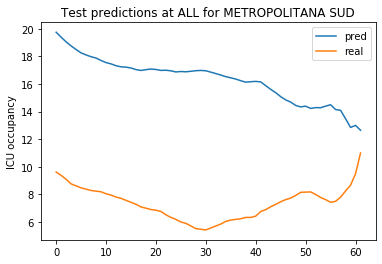

ALL 62 MAE: 8.95 MAPE: 1.28 CUM-MAE: 308.56 CUM-MAPE: 1.28 R2: -0.12
7802
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 2.36 MAPE: 0.12 CUM-MAE: 39.67 CUM-MAPE: 0.06 R2: 0.91
7 56 MAE: 3.81 MAPE: 0.18 CUM-MAE: 35.38 CUM-MAPE: 0.08 R2: 0.64
14 49 MAE: 5.87 MAPE: 0.28 CUM-MAE: 67.46 CUM-MAPE: 0.24 R2: 0.1
21 42 MAE: 7.36 MAPE: 0.37 CUM-MAE: 119.96 CUM-MAPE: 0.46 R2: -0.22
(62, 21)


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


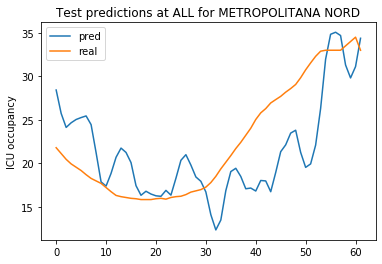

ALL 62 MAE: 4.24 MAPE: 0.19 CUM-MAE: 53.64 CUM-MAPE: 0.14 R2: 0.65
7803
ALL data: 2020-03-01 2021-12-01 641 641
TEST data: 2021-10-01 2021-12-01 62 62
1 62 MAE: 1.8 MAPE: 0.07 CUM-MAE: 35.7 CUM-MAPE: 0.05 R2: 0.83
7 56 MAE: 3.18 MAPE: 0.13 CUM-MAE: 65.58 CUM-MAPE: 0.07 R2: 0.46
14 49 MAE: 5.99 MAPE: 0.24 CUM-MAE: 99.92 CUM-MAPE: 0.14 R2: 0.04
21 42 MAE: 8.03 MAPE: 0.32 CUM-MAE: 126.65 CUM-MAPE: 0.18 R2: 0.12
(62, 21)


/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


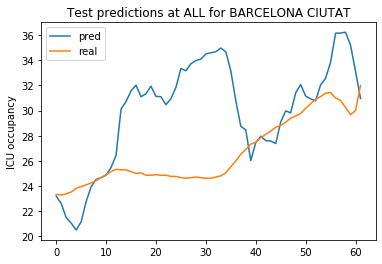

ALL 62 MAE: 3.9 MAPE: 0.15 CUM-MAE: 103.99 CUM-MAPE: 0.11 R2: 0.4


,cls,region,dayPred,num,mae,mape,mae_s,mape_s,maeAcc,mapeAcc,r2
0,uci_occupancy_best_model_region_shallow.02122021.,6100,1,62,2.28,0.53,1.49,0.64,93.24,0.68,0.81
1,uci_occupancy_best_model_region_shallow.02122021.,6100,7,62,1.74,0.38,1.41,0.46,66.87,0.63,0.54
2,uci_occupancy_best_model_region_shallow.02122021.,6100,14,62,1.54,0.26,1.00,0.22,48.85,0.39,0.66
3,uci_occupancy_best_model_region_shallow.02122021.,6100,21,62,1.60,0.26,0.99,0.20,43.80,0.37,0.59
4,uci_occupancy_best_model_region_shallow.02122021.,6100,-1,62,1.48,0.26,1.12,0.25,65.18,0.46,0.81
...,...,...,...,...,...,...,...,...,...,...,...
130,uci_occupancy_best_model_region_vacc_mean7.021...,7803,1,62,1.80,0.07,1.20,0.05,35.70,0.05,0.83
131,uci_occupancy_best_model_region_vacc_mean7.021...,7803,7,62,3.18,0.13,2.95,0.13,65.58,0.07,0.46
132,uci_occupancy_best_model_region_vacc_mean7.021...,7803,14,62,5.99,0.24,4.21,0.19,99.92,0.14,0.04
133,uci_occupancy_best_model_region_vacc_mean7.021...,7803,21,62,8.03,0.32,5.68,0.24,126.65,0.18,0.12


In [27]:
plot = False
perfAll = []
for cls in modelNames[:]:
    print()
    print(cls)
    for cod in selCodisReg:
        print(cod)
        
        #Read data
        dfAll = pd.merge(dfInc[["data",'ingressats_critic_r_'+cod,'ingressats_critic_r_'+cod+'_7']],
                         dfVacAll[["data","recompte_r_"+cod+"_v1","recompte_r_"+cod+"_v2",
                                   "recompte_r_"+cod+"_v1_7","recompte_r_"+cod+"_v2_7"]], 
                         how="left",on="data",suffixes=("",""))
        
        dfAll.fillna(0,inplace=True)

        #Filter dates
        d1 = pd.Timestamp(2021, 12, 2)
        dfAll["data"] = pd.to_datetime(dfAll["data"])
        dfAll = dfAll[dfAll["data"]<=d1]
        
        dfAll = dfAll.iloc[:-1]
        dateFi = str(dfAll.iloc[-1]["data"])[:-9]
        dateIni = str(dfAll.iloc[0]["data"])[:-9]
        
        #Preds data
        fname = cls+cod
        res = np.load("results/res_"+ fname +'.npy')
        resMean = np.nanmean(res, axis=0)
        resMean[np.isnan(resMean)]=0
        resMean[resMean<0]=0
        
        print("ALL data:", dateIni, dateFi, len(dfAll),len(resMean))
        
        #Performance
        #ctte = dateIni
        #ctte = "2021-05-27"
        ctte = "2021-10-01"
        dayIni = dfAll[dfAll.iloc[:,0]>=ctte].iloc[0,0]
        ini = dfAll.iloc[:,0]>=ctte
        real = dfAll.loc[ini]
        real = real.iloc[:,1].astype(float)
        real[real==0]=1 #To avoid errors (div_zero)!!
        pred = resMean[ini,:].astype(float)

        print("TEST data:", ctte, dateFi, len(pred), len(real))  
        
        for j in [0,6,13,20]:        
            result = []          
            for i in range(pred.shape[0]):
                if i+j < len(real):
                    p = pred[i,j]
                    r = real.iloc[i+j]
                    result.append([dayIni+timedelta(days=j)+timedelta(days=j),i,j,p,r])
            result = np.array(result)
        
            #Daily
            mae = np.mean(np.abs(result[:,4]-result[:,3]))
            mape = np.mean(np.abs(result[:,4]-result[:,3])/(result[:,4]+1e-5))
            mae_s = np.std(np.abs(result[:,4]-result[:,3]))
            mape_s = np.std(np.abs(result[:,4]-result[:,3])/(result[:,4]+1e-5))            
            r2 = np.corrcoef(result[:,4].astype(float),result[:,3].astype(float))[0,1]
            
            #CumSum
            realAcc = np.cumsum(result[:,4])
            predAcc = np.cumsum(result[:,3])
            maeAcc = np.mean(np.abs(realAcc-predAcc))
            mapeAcc = np.mean(np.abs(realAcc-predAcc)/(realAcc+1e-5))
                
            print(j+1, len(result), 
                  "MAE:",np.round(mae,2),
                  "MAPE:",np.round(mape,2),
                  "CUM-MAE:",np.round(maeAcc,2),
                  "CUM-MAPE:", np.round(mapeAcc,2),
                  "R2:", np.round(r2,2)
                 )
            
            if mapeAcc > 1000:
                print(realAcc)
                print(predAcc)
                break
                
            if plot and j in [0,6,13,20] and cls == 'uci_occupancy_best_model_region_vacc_mean7.02122021.':
                plt.plot(result[:,3],label="pred")
                plt.plot(result[:,4],label="real")
                plt.title("Test predictions at " + str(j+1) + " for "+str(mapRegId[cod]))
                plt.ylabel("ICU occupancy")
                plt.legend()
                plt.show()
                
            perfAll.append([cls,cod,j+1,len(real), np.round(mae,2), np.round(mape,2),
                            np.round(mae_s,2), np.round(mape_s,2),
                            np.round(maeAcc,2),np.round(mapeAcc,2),np.round(r2,2)])

        #Performance of summing all 21 predictions during the test period
        print(pred.shape)
        result = []
        for i in range(pred.shape[0]):     
            p=0
            r=0
            dim=0
            for j in range(21):
                if i+j < len(real):
                    p += pred[i,j]
                    r += real.iloc[i+j]
                    dim+=1
            result.append([dayIni+timedelta(days=j)+timedelta(days=j),i,p/dim,r/dim])

        result = np.array(result)
        if cls == 'uci_occupancy_best_model_region_vacc_mean7.02122021.':
            plt.plot(result[:,2],label="pred")
            plt.plot(result[:,3],label="real")
            plt.title("Test predictions at ALL for "+str(mapRegId[cod]))
            plt.ylabel("ICU occupancy")
            plt.legend()
            plt.show()
        

        #Daily
        mae = np.mean(np.abs(result[:,3]-result[:,2]))
        mape = np.mean(np.abs(result[:,3]-result[:,2])/(result[:,3]+1e-5))
        mae_s = np.std(np.abs(result[:,3]-result[:,2]))
        mape_s = np.std(np.abs(result[:,3]-result[:,2])/(result[:,3]+1e-5))         
        r2 = np.corrcoef(result[:,3].astype(float),result[:,2].astype(float))[0,1]

        #CumSum
        realAcc = np.cumsum(result[:,3])
        predAcc = np.cumsum(result[:,2])
        maeAcc = np.mean(np.abs(realAcc-predAcc))
        mapeAcc = np.mean(np.abs(realAcc-predAcc)/(realAcc+1e-5))
        
        perfAll.append([cls,cod,-1,len(real), np.round(mae,2), np.round(mape,2),
                            np.round(mae_s,2), np.round(mape_s,2),
                        np.round(maeAcc,2),np.round(mapeAcc,2),np.round(r2,2)]) 
        
        print("ALL", len(result), 
              "MAE:",np.round(mae,2),
              "MAPE:",np.round(mape,2),
              "CUM-MAE:",np.round(maeAcc,2),
              "CUM-MAPE:", np.round(mapeAcc,2),
              "R2:", np.round(r2,2)
             )        
dfPerf = pd.DataFrame(perfAll, columns=["cls","region","dayPred","num","mae","mape","mae_s","mape_s","maeAcc","mapeAcc","r2"])
dfPerf

In [28]:
dfPerf[dfPerf["cls"]=="uci_occupancy_best_model_region_vacc_mean7.02122021."].groupby(["dayPred"]).agg("mean")

,num,mae,mape,mae_s,mape_s,maeAcc,mapeAcc,r2
dayPred,,,,,,,,
-1,62,2.976667,0.372222,1.594444,0.197778,74.971111,0.348889,0.304444
1,62,1.703333,0.301111,1.014444,0.242222,38.683333,0.232222,0.724444
7,62,3.008889,0.427778,1.693333,0.280000,66.171111,0.362222,0.434444
14,62,3.914444,0.552222,2.071111,0.354444,72.562222,0.414444,0.224444
21,62,4.933333,0.677778,2.327778,0.385556,86.218889,0.563333,-0.094444


In [128]:
grp = dfPerf[["cls","dayPred","region","r2"]].groupby(["cls","dayPred","region"]).agg(["mean","std"]).reset_index()
grp["r2_m"] = grp["r2"]["mean"]
grp["r2_m"] = grp["r2_m"].astype(float)
pvt = pd.pivot(grp, index=["cls","dayPred"],columns="region",values="r2_m")
#display(pvt)
display(pvt.mean(axis=1).round(2))
display(pvt.std(axis=1).round(2))

cls                                                     dayPred
uci_occupancy_best_model_region_shallow.02122021.       -1         0.35
                                                         1         0.75
                                                         7         0.41
                                                         14        0.23
                                                         21       -0.09
uci_occupancy_best_model_region_shallow_vacc.02122021.  -1         0.44
                                                         1         0.72
                                                         7         0.34
                                                         14        0.12
                                                         21       -0.14
uci_occupancy_best_model_region_vacc_mean7.02122021.    -1         0.30
                                                         1         0.72
                                                         7         0.43


cls                                                     dayPred
uci_occupancy_best_model_region_shallow.02122021.       -1         0.38
                                                         1         0.19
                                                         7         0.26
                                                         14        0.38
                                                         21        0.34
uci_occupancy_best_model_region_shallow_vacc.02122021.  -1         0.27
                                                         1         0.20
                                                         7         0.23
                                                         14        0.45
                                                         21        0.39
uci_occupancy_best_model_region_vacc_mean7.02122021.    -1         0.56
                                                         1         0.23
                                                         7         0.29


/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

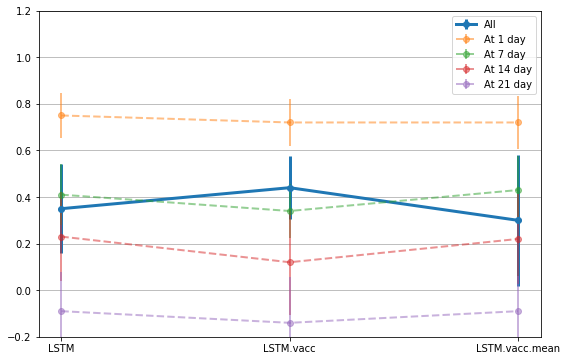

In [111]:
y = pvt.mean(axis=1).round(2).reset_index(drop=False)
y = pd.DataFrame(y)
y["score"] = y[0]
y["cls"][y["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
y.sort_values("cls",inplace=True)
yAll = y[y["dayPred"]==-1]
y1 = y[y["dayPred"]==1]
y7 = y[y["dayPred"]==7]
y14 = y[y["dayPred"]==14]
y21 = y[y["dayPred"]==21]

yAll = yAll["score"]
y1 = y1["score"]
y7 = y7["score"]
y14 = y14["score"]
y21 = y21["score"]

error = pvt.std(axis=1).round(2).reset_index(drop=False)
error = pd.DataFrame(error)
error["score"] = error[0]
error["cls"][error["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
error.sort_values("cls",inplace=True)
errorAll = error[error["dayPred"]==-1]
error1 = error[error["dayPred"]==1]
error7 = error[error["dayPred"]==7]
error14 = error[error["dayPred"]==14]
error21 = error[error["dayPred"]==21]

errorAll = errorAll["score"]
error1 = error1["score"]
error7 = error7["score"]
error14 = error14["score"]
error21 = error21["score"]

plt.figure(figsize=(9,6))
plt.errorbar(range(len(yAll)), yAll, errorAll/2., label="All", linestyle='-', marker='o', linewidth=3)
plt.errorbar(range(len(y1)), y1, error1/2., label="At 1 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y7)), y7, error7/2., label="At 7 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y14)), y14, error14/2., label="At 14 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y21)), y21, error21/2., label="At 21 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)

plt.xticks(range(len(yAll)),["LSTM","LSTM.vacc","LSTM.vacc.mean"])
plt.ylim(-0.2,1.2)
plt.legend(loc="upper right")
plt.grid(axis='y')
plt.show()

In [129]:
grp = dfPerf[["cls","dayPred","region","mae"]].groupby(["cls","dayPred","region"]).agg(["mean","std"]).reset_index()
grp["mae_m"] = grp["mae"]["mean"]
grp["mae_m"] = grp["mae_m"].astype(float)
pvt = pd.pivot(grp, index=["cls","dayPred"],columns="region",values="mae_m")
#display(pvt)
display(pvt.mean(axis=1).round(2))
display(pvt.std(axis=1).round(2))

cls                                                     dayPred
uci_occupancy_best_model_region_shallow.02122021.       -1         4.42
                                                         1         3.39
                                                         7         4.09
                                                         14        5.40
                                                         21        6.83
uci_occupancy_best_model_region_shallow_vacc.02122021.  -1         4.68
                                                         1         4.38
                                                         7         4.78
                                                         14        5.47
                                                         21        6.17
uci_occupancy_best_model_region_vacc_mean7.02122021.    -1         2.98
                                                         1         1.70
                                                         7         3.01


cls                                                     dayPred
uci_occupancy_best_model_region_shallow.02122021.       -1         4.11
                                                         1         3.78
                                                         7         4.16
                                                         14        4.87
                                                         21        6.19
uci_occupancy_best_model_region_shallow_vacc.02122021.  -1         4.10
                                                         1         3.96
                                                         7         4.21
                                                         14        5.03
                                                         21        6.08
uci_occupancy_best_model_region_vacc_mean7.02122021.    -1         2.64
                                                         1         1.29
                                                         7         2.79


/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

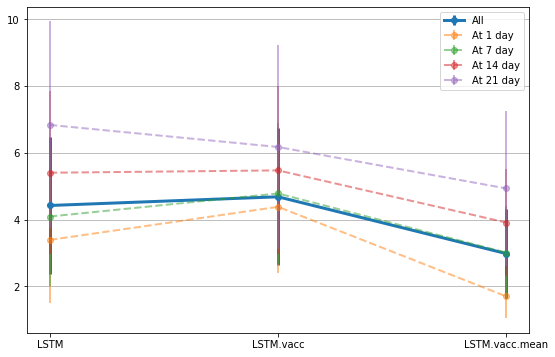

In [113]:
y = pvt.mean(axis=1).round(2).reset_index(drop=False)
y = pd.DataFrame(y)
y["score"] = y[0]
y["cls"][y["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
y.sort_values("cls",inplace=True)
yAll = y[y["dayPred"]==-1]
y1 = y[y["dayPred"]==1]
y7 = y[y["dayPred"]==7]
y14 = y[y["dayPred"]==14]
y21 = y[y["dayPred"]==21]

yAll = yAll["score"]
y1 = y1["score"]
y7 = y7["score"]
y14 = y14["score"]
y21 = y21["score"]

error = pvt.std(axis=1).round(2).reset_index(drop=False)
error = pd.DataFrame(error)
error["score"] = error[0]
error["cls"][error["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
error.sort_values("cls",inplace=True)
errorAll = error[error["dayPred"]==-1]
error1 = error[error["dayPred"]==1]
error7 = error[error["dayPred"]==7]
error14 = error[error["dayPred"]==14]
error21 = error[error["dayPred"]==21]

errorAll = errorAll["score"]
error1 = error1["score"]
error7 = error7["score"]
error14 = error14["score"]
error21 = error21["score"]

plt.figure(figsize=(9,6))
plt.errorbar(range(len(yAll)), yAll, errorAll/2., label="All", linestyle='-', marker='o', linewidth=3)
plt.errorbar(range(len(y1)), y1, error1/2., label="At 1 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y7)), y7, error7/2., label="At 7 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y14)), y14, error14/2., label="At 14 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y21)), y21, error21/2., label="At 21 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)

plt.xticks(range(len(yAll)),["LSTM","LSTM.vacc","LSTM.vacc.mean"])
plt.legend()
plt.grid(axis='y')
plt.show()

In [29]:
grp = dfPerf[["cls","dayPred","region","mape"]].groupby(["cls","dayPred","region"]).agg(["mean","std"]).reset_index()
grp["mape_m"] = grp["mape"]["mean"]
grp["mape_m"] = grp["mape_m"].astype(float)
pvt = pd.pivot(grp, index=["cls","dayPred"],columns="region",values="mape_m")
#display(pvt)
display(pvt.mean(axis=1).round(2))
display(pvt.std(axis=1).round(2))

cls                                                     dayPred
uci_occupancy_best_model_region_shallow.02122021.       -1         0.53
                                                         1         0.55
                                                         7         0.59
                                                         14        0.70
                                                         21        0.84
uci_occupancy_best_model_region_shallow_vacc.02122021.  -1         0.54
                                                         1         0.64
                                                         7         0.66
                                                         14        0.69
                                                         21        0.70
uci_occupancy_best_model_region_vacc_mean7.02122021.    -1         0.37
                                                         1         0.30
                                                         7         0.43


cls                                                     dayPred
uci_occupancy_best_model_region_shallow.02122021.       -1         0.55
                                                         1         0.56
                                                         7         0.63
                                                         14        0.70
                                                         21        0.77
uci_occupancy_best_model_region_shallow_vacc.02122021.  -1         0.44
                                                         1         0.46
                                                         7         0.51
                                                         14        0.57
                                                         21        0.59
uci_occupancy_best_model_region_vacc_mean7.02122021.    -1         0.36
                                                         1         0.25
                                                         7         0.43


/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/homedtic/jrafael/anaconda3/envs/deeplung/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

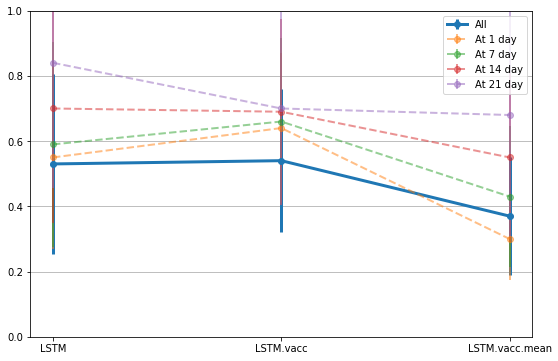

In [115]:
y = pvt.mean(axis=1).round(2).reset_index(drop=False)
y = pd.DataFrame(y)
y["score"] = y[0]
y["cls"][y["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
y.sort_values("cls",inplace=True)
yAll = y[y["dayPred"]==-1]
y1 = y[y["dayPred"]==1]
y7 = y[y["dayPred"]==7]
y14 = y[y["dayPred"]==14]
y21 = y[y["dayPred"]==21]

yAll = yAll["score"]
y1 = y1["score"]
y7 = y7["score"]
y14 = y14["score"]
y21 = y21["score"]

error = pvt.std(axis=1).round(2).reset_index(drop=False)
error = pd.DataFrame(error)
error["score"] = error[0]
error["cls"][error["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
error.sort_values("cls",inplace=True)
errorAll = error[error["dayPred"]==-1]
error1 = error[error["dayPred"]==1]
error7 = error[error["dayPred"]==7]
error14 = error[error["dayPred"]==14]
error21 = error[error["dayPred"]==21]

errorAll = errorAll["score"]
error1 = error1["score"]
error7 = error7["score"]
error14 = error14["score"]
error21 = error21["score"]

plt.figure(figsize=(9,6))
plt.errorbar(range(len(yAll)), yAll, errorAll/2., label="All", linestyle='-', marker='o', linewidth=3)
plt.errorbar(range(len(y1)), y1, error1/2., label="At 1 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y7)), y7, error7/2., label="At 7 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y14)), y14, error14/2., label="At 14 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)
plt.errorbar(range(len(y21)), y21, error21/2., label="At 21 day", linestyle='--', marker='o', linewidth=2,alpha=0.5)

plt.xticks(range(len(yAll)),["LSTM","LSTM.vacc","LSTM.vacc.mean"])
plt.ylim(0,1)
plt.legend()
plt.grid(axis='y')
plt.show()

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

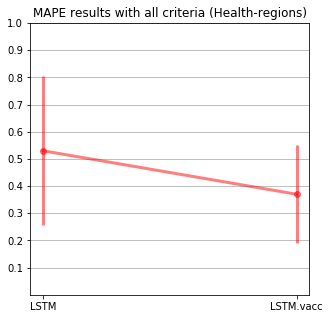

In [32]:
y = pvt.mean(axis=1).round(2).reset_index(drop=False)
y = pd.DataFrame(y)
y["score"] = y[0]
y["cls"][y["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
y["cls"][y["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
y.sort_values("cls",inplace=True)
yAll = y[y["dayPred"]==-1]
yAll = yAll["score"]
yAll = yAll.iloc[[0,2]]

error = pvt.std(axis=1).round(2).reset_index(drop=False)
error = pd.DataFrame(error)
error["score"] = error[0]
error["cls"][error["cls"]=="ingressos_total_best_model_region_shallow.02122021."] = "LSTM"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_shallow.02122021."] = "LSTM.vacc"
error["cls"][error["cls"]=="ingressos_total_best_model_region_vacc_mean7.02122021."] = "LSTM.vacc.mean"
error.sort_values("cls",inplace=True)
errorAll = error[error["dayPred"]==-1]
errorAll = errorAll["score"]
errorAll = errorAll.iloc[[0,2]]

plt.figure(figsize=(5,5))
plt.errorbar(range(len(yAll)), yAll, errorAll/2., label="All", linestyle='-', marker='o', linewidth=3, c="red", alpha=0.5)
plt.xticks(range(len(yAll)),["LSTM","LSTM.vacc"])
plt.title("MAPE results with all criteria (Health-regions)")
plt.grid(axis='y')
plt.yticks([0.1*i for i in range(1,11)])
plt.ylim(0,1)
plt.show()

In [136]:
grp = dfPerf[dfPerf["dayPred"]==-1][["cls","dayPred","region","mape","mape_s"]].groupby(["cls","region"]).agg(["mean","std"]).reset_index()
grp["mape_m"] = grp["mape"]["mean"]
grp["mape_m"] = grp["mape_m"].astype(float)
grp["mape_std"] = grp["mape_s"]["mean"]
grp["mape_std"] = grp["mape_std"].astype(float)
pvt = pd.pivot(grp, index=["cls"],columns="region",values="mape_m")
display(pvt.iloc[2])
pvt = pd.pivot(grp, index=["cls"],columns="region",values="mape_std")
display(pvt.iloc[2])

region
6100    0.16
6200    0.16
6300    0.44
6400    0.28
6700    0.21
7100    0.48
7801    1.28
7802    0.19
7803    0.15
Name: uci_occupancy_best_model_region_vacc_mean7.02122021., dtype: float64

region
6100    0.15
6200    0.07
6300    0.42
6400    0.19
6700    0.10
7100    0.15
7801    0.44
7802    0.12
7803    0.14
Name: uci_occupancy_best_model_region_vacc_mean7.02122021., dtype: float64

In [139]:
grp = dfPerf[dfPerf["dayPred"]==-1][["cls","dayPred","region","r2"]].groupby(["cls","region"]).agg(["mean","std"]).reset_index()
grp["r2_m"] = grp["r2"]["mean"]
grp["r2_m"] = grp["r2_m"].astype(float)
pvt = pd.pivot(grp, index=["cls"],columns="region",values="r2_m")
display(pvt.iloc[2])

region
6100    0.77
6200   -0.65
6300   -0.44
6400    0.81
6700    0.73
7100    0.59
7801   -0.12
7802    0.65
7803    0.40
Name: uci_occupancy_best_model_region_vacc_mean7.02122021., dtype: float64

In [142]:
grp = dfPerf[dfPerf["dayPred"]==-1][["cls","dayPred","region","mae","mae_s"]].groupby(["cls","region"]).agg(["mean"]).reset_index()
grp["mae_m"] = grp["mae"]["mean"]
grp["mae_m"] = grp["mae_m"].astype(float)
grp["mae_std"] = grp["mae_s"]["mean"]
grp["mae_std"] = grp["mae_std"].astype(float)
pvt = pd.pivot(grp, index=["cls"],columns="region",values="mae_m")
display(pvt.iloc[2])
pvt_s = pd.pivot(grp, index=["cls"],columns="region",values="mae_std")
display(pvt_s.iloc[2])


region
6100    0.97
6200    1.61
6300    0.74
6400    3.59
6700    2.27
7100    0.52
7801    8.95
7802    4.24
7803    3.90
Name: uci_occupancy_best_model_region_vacc_mean7.02122021., dtype: float64

region
6100    0.67
6200    0.68
6300    0.54
6400    2.59
6700    1.31
7100    0.15
7801    2.10
7802    2.95
7803    3.36
Name: uci_occupancy_best_model_region_vacc_mean7.02122021., dtype: float64

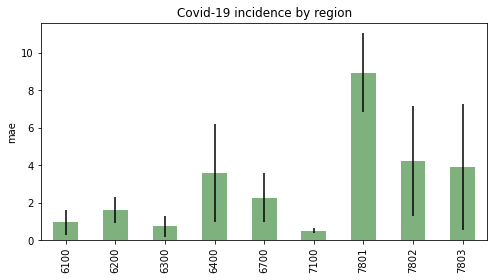

In [143]:
pvt.iloc[2].plot(kind='bar',figsize=(8,4),color="darkgreen",alpha=0.5,yerr=pvt_s.iloc[2])
plt.ylim(0,)
plt.ylabel("mae")
#plt.axhline(0.5,ls="--",c="black",linewidth=0.5)
plt.axhline(0.,ls="-",c="black",linewidth=1)
#plt.axhline(-0.5,ls="--",c="black",linewidth=0.5)
plt.title("Covid-19 incidence by region")
plt.xlabel("")
plt.show()

In [37]:
grp = dfPerf[["cls","dayPred","r2"]].groupby(["cls","dayPred"]).agg(["mean","std"]).reset_index()
grp["r2_m"] = grp["r2"]["mean"]
grp["r2_m"] = grp["r2_m"].astype(float)
pvt = pd.pivot(grp, index="cls",columns="dayPred",values="r2_m")
display(pvt)
display(pvt.mean(axis=1))
display(pvt.std(axis=1))

dayPred,-1,1,7,14,21
cls,,,,,
uci_occupancy_best_model_region_vacc_mean7.02122021.,0.771111,0.724444,0.434444,0.224444,-0.094444


cls
uci_occupancy_best_model_region_vacc_mean7.02122021.    0.412
dtype: float64

cls
uci_occupancy_best_model_region_vacc_mean7.02122021.    0.360121
dtype: float64

([<matplotlib.axis.XTick at 0x154c82f54240>], [Text(0, 0, 'LSTM_VACC_MEAN')])

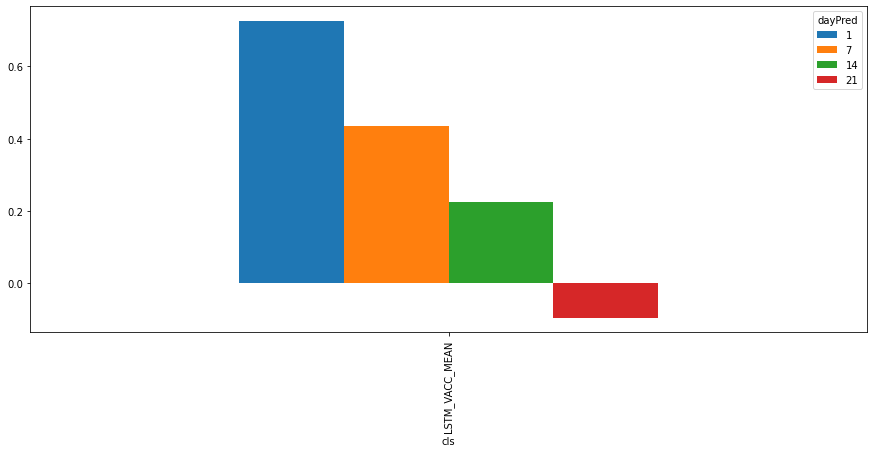

In [38]:
pvt.iloc[[0],1:].plot(kind='bar',figsize=(15,6))
plt.xticks(range(1),["LSTM_VACC_MEAN"])